In [ ]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress


import LE as le
import LP as lp
import iterative as iterative
import graph_vis as viz
import logger_creator

from graph_gen import create_delegation_graph
import graph_tools
import networkx as nx
import pandas as pd

In [ ]:
range_x = range(0, 1001, 100)

logger, handler = logger_creator.create_logger("benchmarking")

times_le = []
times_lp = []
times_iterative = []

for num_nodes in range_x:
    print(num_nodes)

    big_loop = nx.DiGraph()
    # We're creating a graph with one node too many technically
    for i in range(num_nodes):
        if i == 0:
            # Add split edge: 0.9 to the next node
            big_loop.add_edge(i, (i + 1) % num_nodes, weight=0.9)
            # Add the external node and edge with weight 0.1
            big_loop.add_edge(i, num_nodes, weight=0.1)  # external node has index `n`
        else:
            big_loop.add_edge(i, (i + 1) % num_nodes, weight=1.0)
                            
    delegations_orig = graph_tools.nx_graph_to_dict(big_loop)
    delegations = graph_tools.invert_graph(delegations_orig)
    nodes = list(big_loop)

    # Verify the solutions are equal
    powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
    powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
    powers_iter = iterative.iterate_delegations(delegations, nodes)

    if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-6 for k in powers_le):
        logger.error("Powers do not match")
        logger.error(f"LE: {powers_le}")
        logger.error(f"LP: {powers_lp}")
        print("Mismatching powers in LE and LP. Check the log file for details.")
        break

    for node in sinks_le:
        if (powers_lp[node] - powers_iter[node] < 0.01):
            continue
        else: 
            logger.error("Powers do not match")
            logger.error(f"LP: {powers_lp}")
            logger.error(f"Iterative: {powers_iter}")
            print("Mismatching powers in LP and Iterative. Check the log file for details.")
            break

    n = 5
    if 0 <= num_nodes < 100:
        n = 100
    elif 100 <= num_nodes < 500:
        n = 20

    # LE
    le_model = le.set_up(delegations, nodes)
    start_time = time.time()
    for _ in range(n):
        le.solve(*le_model)
    end_time = time.time()
    
    times_le.append((end_time - start_time) / n)

    # LP
    lp_model = lp.set_up(delegations, nodes)
    start_time = time.time()
    for _ in range(n):
        lp.solve(*lp_model)
    end_time = time.time()

    times_lp.append((end_time - start_time) / n)

    # Iterative
    start_time = time.time()
    for _ in range(n):
        p = iterative.iterate_delegations(delegations, nodes)
    end_time = time.time()

    times_iterative.append((end_time - start_time) / n)

logger.removeHandler(handler)
handler.close()

x = list(range_x)

0
100
200
300
400
500
600
700
800
900
1000


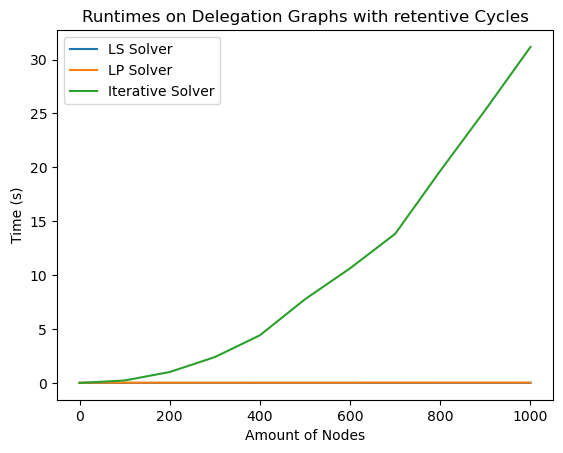

In [7]:
plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on Delegation Graphs with retentive Cycles")
plt.show()

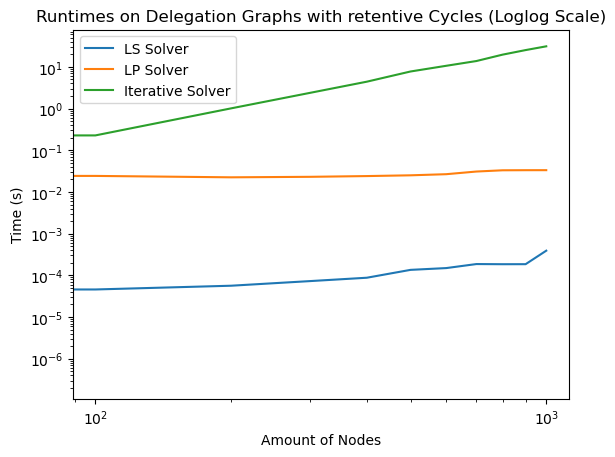

In [8]:

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on Delegation Graphs with retentive Cycles (Loglog Scale)")
plt.loglog()
plt.show()

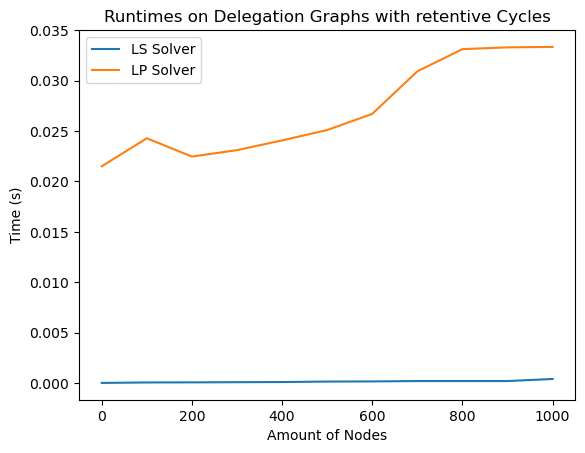

In [9]:
plt.figure()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
#plt.plot(x, times_terative, label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on Delegation Graphs with retentive Cycles")
plt.show()

In [10]:
print("x = ", x)
print("times_iterative = ", times_iterative)
print("times_le = ", times_le)
print("times_lp = ", times_lp)

x =  [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
times_iterative =  [6.302118301391601e-05, 0.22739354372024537, 1.012834942340851, 2.3977330565452575, 4.420719790458679, 7.763039779663086, 10.636189794540405, 13.835212421417236, 19.67817978858948, 25.329606008529662, 31.171802616119386]
times_le =  [2.7179718017578123e-07, 4.584789276123047e-05, 5.6409835815429686e-05, 7.294416427612304e-05, 8.770227432250977e-05, 0.0001354217529296875, 0.00014944076538085936, 0.00018663406372070311, 0.00018506050109863282, 0.000185394287109375, 0.000390625]
times_lp =  [0.02149966239929199, 0.024281299114227294, 0.022467601299285888, 0.023103952407836914, 0.0240678071975708, 0.02509922981262207, 0.026700353622436522, 0.03092498779296875, 0.033128213882446286, 0.033304786682128905, 0.033347797393798825]


In [ ]:
y = times_le[1:]

results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_le = pd.DataFrame(results).T

print("Results for LS:")
display(df_results_le)


y = times_lp[1:]

# Store model fits and R² values
results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_lp = pd.DataFrame(results).T

print("Results for LP:")
display(df_results_lp)

y = times_iterative[1:]

# Store model fits and R² values
results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_iterative = pd.DataFrame(results).T

print("Results for Iterative:")
display(df_results_iterative)

,R2,slope,intercept
Power law,0.883145,8.396220e-01,-14.132615
Exponential,0.941390,2.098770e-03,-10.152137
Linear,0.789010,2.955928e-07,-0.000013
Log-linear,0.617909,1.080445e-04,-0.000511


,R2,slope,intercept
Power law,0.657641,0.178966,-4.694759
Exponential,0.870792,0.000499,-3.874499
Linear,0.867974,0.000014,0.019984
Log-linear,0.649622,0.004976,-0.002786


,R2,slope,intercept
Power law,0.999523,2.136852,-11.309721
Exponential,0.901788,0.004914,-0.944311
Linear,0.938650,0.034317,-7.227260
Log-linear,0.727932,12.482298,-64.689612


# Just LS and LP

In [ ]:
range_x = range(0, 200001, 10000)

logger, handler = logger_creator.create_logger("benchmarking")

times_le = []
times_lp = []
times_iterative = []

for num_nodes in range_x:
    print(num_nodes)

    big_loop = nx.DiGraph()
    # We're creating a graph with one node too many technically
    for i in range(num_nodes):
        if i == 0:
            # Add split edge: 0.9 to the next node
            big_loop.add_edge(i, (i + 1) % num_nodes, weight=0.9)
            # Add the external node and edge with weight 0.1
            big_loop.add_edge(i, num_nodes, weight=0.1)  # external node has index `n`
        else:
            big_loop.add_edge(i, (i + 1) % num_nodes, weight=1.0)
                            
    delegations_orig = graph_tools.nx_graph_to_dict(big_loop)
    delegations = graph_tools.invert_graph(delegations_orig)
    nodes = list(big_loop)

    # # Verify the solutions are equal
    # powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
    # powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
    # powers_iter = iterative.iterate_delegations(delegations, nodes)

    # if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-6 for k in powers_le):
    #     logger.error("Powers do not match")
    #     logger.error(f"LE: {powers_le}")
    #     logger.error(f"LP: {powers_lp}")
    #     print("Mismatching powers in LE and LP. Check the log file for details.")
    #     break

    # for node in sinks_le:
    #     if (powers_lp[node] - powers_iter[node] < 0.01):
    #         continue
    #     else: 
    #         logger.error("Powers do not match")
    #         logger.error(f"LP: {powers_lp}")
    #         logger.error(f"Iterative: {powers_iter}")
    #         print("Mismatching powers in LP and Iterative. Check the log file for details.")
    #         break

    n = 5
    if 0 <= num_nodes < 50000:
        n = 50
    elif 10000 <= num_nodes < 100000:
        n = 20

    # LE
    le_model = le.set_up(delegations, nodes)
    start_time = time.time()
    for _ in range(n):
        le.solve(*le_model)
    end_time = time.time()
    
    times_le.append((end_time - start_time) / n)

    # LP
    lp_model = lp.set_up(delegations, nodes)
    start_time = time.time()
    for _ in range(n):
        lp.solve(*lp_model)
    end_time = time.time()

    times_lp.append((end_time - start_time) / n)

    # # Iterative
    # start_time = time.time()
    # for _ in range(n):
    #     p = iterative.iterate_delegations(delegations, nodes)
    # end_time = time.time()

    times_iterative.append((end_time - start_time) / n)

logger.removeHandler(handler)
handler.close()

x = list(range_x)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


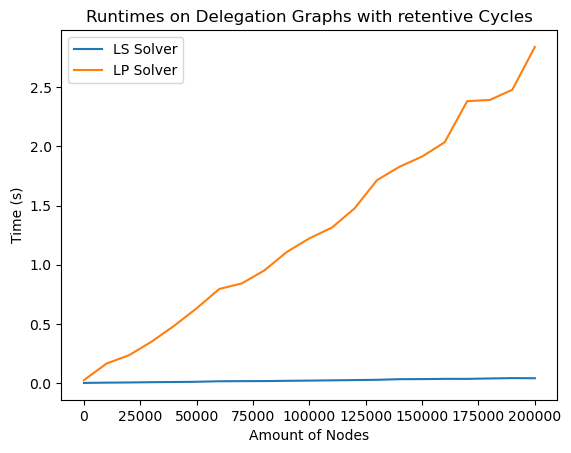

In [54]:
plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
#plt.plot(x, times_iterative, label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on Delegation Graphs with retentive Cycles")
plt.show()

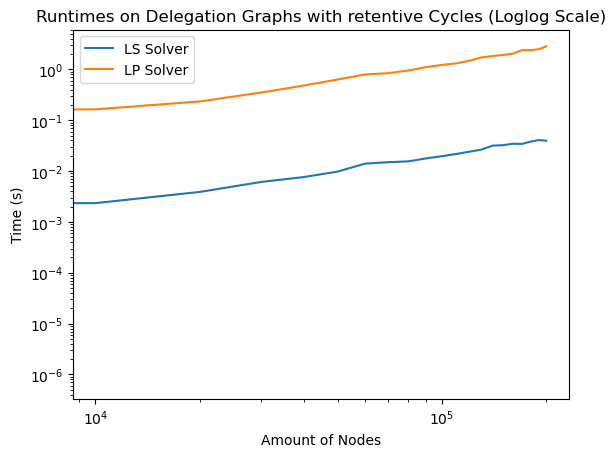

In [55]:
plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
#plt.plot(x, times_iterative, label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on Delegation Graphs with retentive Cycles (Loglog Scale)")
plt.loglog()
plt.show()

In [48]:
print("x = ", x)
print("times_iterative = ", times_iterative)
print("times_le = ", times_le)
print("times_lp = ", times_lp)

x =  [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000]
times_iterative =  [0.023606295585632323, 0.16356314182281495, 0.2342326021194458, 0.3491244840621948, 0.48290120124816893, 0.6314512968063355, 0.7944934844970704, 0.8415459036827088, 0.951225197315216, 1.107788097858429, 1.222515630722046, 1.3139601707458497, 1.475318431854248, 1.7150614261627197, 1.8287154197692872, 1.9145443916320801, 2.035285997390747, 2.3833611965179444, 2.3931406021118162, 2.4792813777923586, 2.841734838485718]
times_le =  [7.009506225585937e-07, 0.0023427963256835937, 0.003887777328491211, 0.006094603538513183, 0.007638044357299804, 0.009772145748138427, 0.01400994062423706, 0.014947104454040527, 0.015544605255126954, 0.01775078773498535, 0.019635820388793947, 0.021710014343261717, 0.02406320571899414, 0.026414966583251952, 0.03165402412414551, 0.03231935501098633, 0.034482812881469725, 0.0342061996459960

In [ ]:
y = times_le[1:]

results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_le = pd.DataFrame(results).T

display(df_results_le)


y = times_lp[1:]

# Store model fits and R² values
results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_lp = pd.DataFrame(results).T

display(df_results_lp)

,R2,slope,intercept
Power law,0.994221,9.937459e-01,-15.322838
Exponential,0.879975,1.284317e-05,-5.415091
Linear,0.991496,2.092739e-07,-0.000246
Log-linear,0.854075,1.413887e-02,-0.138425


,R2,slope,intercept
Power law,0.990170,0.994517,-11.204649
Exponential,0.908853,0.000013,-1.313982
Linear,0.991023,0.000014,-0.077801
Log-linear,0.822781,0.906966,-8.915348


# Visualize Example Loops

In [ ]:
big_loop = nx.DiGraph()
num_nodes = 9
# We're creating a graph with one node too many technically
for i in range(num_nodes):
    if i == 0:
        # Add split edge: 0.9 to the next node
        big_loop.add_edge(i, (i + 1) % num_nodes, weight=0.9)
        # Add the external node and edge with weight 0.1
        big_loop.add_edge(i, num_nodes, weight=0.1)  # external node has index `n`
    else:
        big_loop.add_edge(i, (i + 1) % num_nodes, weight=1.0)
            
delegations_orig = graph_tools.nx_graph_to_dict(big_loop)
delegations = graph_tools.invert_graph(delegations_orig)
nodes = list(big_loop)

powers, sinks = le.resolve_delegations(delegations, nodes)

viz.visualize_delegation_graph(delegations_orig, powers)

Parsing the data...Done


Graph visualization failed because no ports were found or there was another error.


No trigger


# Another Example

In [29]:
delegations_orig = {
    1: {0: 0.1, 2: 0.9},
    2: {1: 0.1, 3: 0.9},
    3: {2: 1.0}
}

nodes = [0, 1, 2, 3]

delegations = graph_tools.invert_graph(delegations_orig)
powers_le, sinks_le = le.resolve_delegations(delegations, nodes)

viz.visualize_delegation_graph(delegations_orig, powers_le)



Parsing the data...Done


/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/jaal/datasets/parse_dataframe.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '1' '2' '2' '3']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  edge_df.loc[:, ['from', 'to']] = edge_df.loc[:, ['from', 'to']].astype(str)
/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/jaal/datasets/parse_dataframe.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0' '2' '1' '3' '2']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  edge_df.loc[:, ['from', 'to']] = edge_df.loc[:, ['from', 'to']].astype(str)
/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/jaal/datasets/parse_dataframe.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas

Graph visualization failed because no ports were found or there was another error.


No trigger


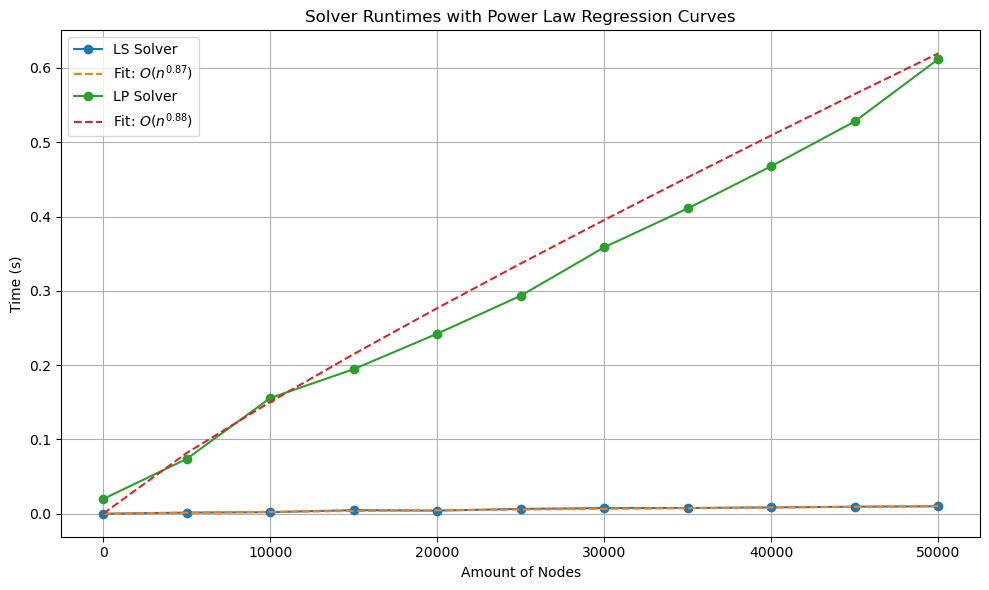

In [36]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(x)

# === Slopes and intercepts from log-log regression ===
# log(y) = slope * log(x) + intercept
slope_le, intercept_le = 0.87, -14.0
slope_lp, intercept_lp = 0.88, -10.0
# slope_iter, intercept_iter = 1.4, -8.2

# === Compute fitted power curves: y = C * x^slope
def power_fit(x, slope, intercept):
    return np.exp(intercept) * x**slope

fit_le = power_fit(x, slope_le, intercept_le)
fit_lp = power_fit(x, slope_lp, intercept_lp)
# fit_iter = power_fit(x, slope_iter, intercept_iter)

# === Plot
plt.figure(figsize=(10, 6))

plt.plot(x, times_le, 'o-', label='LS Solver')
plt.plot(x, fit_le, '--', label=fr'Fit: $O(n^{{{slope_le:.2f}}})$')

plt.plot(x, times_lp, 'o-', label='LP Solver')
plt.plot(x, fit_lp, '--', label=fr'Fit: $O(n^{{{slope_lp:.2f}}})$')

# plt.plot(x, times_iterative, 'o-', label='Iterative Solver')
# plt.plot(x, fit_iter, '--', label=fr'Fit: $O(n^{{{slope_iter:.2f}}})$')

plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Solver Runtimes with Power Law Regression Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
times_lp

[0.019785902500152587,
 0.07373166084289551,
 0.15566205978393555,
 0.19452511072158812,
 0.24230149984359742,
 0.2933385968208313,
 0.3585745573043823,
 0.41089054346084597,
 0.46774715185165405,
 0.527964198589325,
 0.611868953704834]